<a href="https://colab.research.google.com/github/jychen630/dl-fall22-mini-project/blob/main/Gustavo_Mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
#!pip install -e git+https://github.com/marcoancona/TorchPruner.git#egg=torchpruner

In [146]:
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

set_up_ssl()

In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.utils.prune as prune
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

import os
import sys
import time
import math
import argparse
import humanize
import numpy as np
import matplotlib.pyplot as plt

In [148]:
term_width = 5
TOTAL_BAR_LENGTH = 7
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [149]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # pruning model parameters in the first convolution layer

        # prune.random_unstructured(self.conv1, name='weight', amount=0.6)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        # pruning model parameters in the second convolution layer

        # prune.random_unstructured(self.conv2, name='weight', amount=0.6)
        # prune.remove(self.conv2, 'weight')

        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)

        # prune.random_unstructured(self.conv1, name='weight', amount=0.5)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        
        # prune.random_unstructured(self.conv2, name='weight', amount=0.5)
        # prune.remove(self.conv2, 'weight')

        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        
        # prune.random_unstructured(self.conv3, name='weight', amount=0.5)
        # prune.remove(self.conv3, 'weight')

        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        #out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        
        # prune.random_unstructured(self.conv1, name='weight', amount=0.5)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=4)
        # removing the 4th layer to reduce the size of the network
        #self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

        # prune.random_unstructured(self.linear, name='weight', amount=0.5)
        # prune.remove(self.linear, 'weight')

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # removing the 4th layer to reduce the size of the network
        #out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


#seems not used
# def test():
#     net = ResNet18()
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())


In [150]:

LOCAL_M1 = False

if LOCAL_M1:
    device = 'cuda' if torch.cuda.is_available() else 'mps'
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #transforms.RandomErasing()
  
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# constructing validation set

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

torch.manual_seed(43)
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)
print("The length of a train set is ", len(train_ds))
print("The length of a validation set is ", len(val_ds))
print("The length of a test set is ", len(testset))

trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

net = ResNet18() # 11.2 params
#net.fc = nn.Identity()
#net = ResNet50() # 23.5

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
The length of a train set is  45000
The length of a validation set is  5000
The length of a test set is  10000


In [151]:
layers = list(net.children())

print(len(layers))

print(net)
# print("layers[0]: ", layers[0])
# print("layers[1]: ", layers[1])
# print("layers[2]: ", layers[2])
# print("layers[3]: ", layers[3])
# print("layers[4]: ", layers[4])
# print("layers[5]: ", layers[5])
# print("layers[6]: ", layers[6])

6
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [152]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_params(model):
  print("Number of parameters ", humanize.intword(count_parameters(model)))
  return

In [153]:
print("The number of parameters is ")
print_params(net)

The number of parameters is 
Number of parameters  2.8 million


In [154]:
# from torchsummary import summary

# def print_model_summary(model):
#   print(summary(model.to(device), (3, 32, 32)))

# print_model_summary(net)

In [155]:
def print_model_layers(model):
  for name, param in model.named_parameters():
    print(name, param.size())

print_model_layers(net)

conv1.weight torch.Size([64, 3, 3, 3])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.shortcut.0.weight torch.Size([128, 64, 1, 1])
layer2.0.shortcut.1.weight torch.Size([128])
layer2.0.shortcut.1.bias torch.Size([128])
layer2.1.conv1.weight torch.Siz

In [156]:
def freeze_layer(layer_name):
  for param_name, param in net.named_parameters():
    if layer_name in param_name:
      param.requires_grad = False

In [157]:
# freeze_layer("layer3")

In [158]:
print_model_summary(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [159]:
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

lr = 0.1
lr = 0.01
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)
optimizer = optim.SGD(net.parameters(), lr=lr,
                       momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

train_acc_array, train_loss_array = [], [] # for plotting
val_acc_array, val_loss_array = [], [] # for plotting

In [160]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_acc = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        train_acc=100.*correct/total
        progress_bar(batch_idx, len(trainloader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

    train_acc_array.append(train_acc) # for plottting
    train_loss_array.append(train_loss) # for plottting


In [161]:
def evaluate(epoch): # validation
   
    global best_acc
    net.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(val_loader), 'Valid Loss: %.3f | Valid Acc: %.3f%% (%d/%d)'
                         % (valid_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    valid_acc = 100.*correct/total
    if valid_acc > best_acc:
        print('Saving..')
        state = {
            'net_state_dict': net.state_dict(),
            'acc': valid_acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = valid_acc
    val_acc_array.append(valid_acc) # for plottting
    val_loss_array.append(valid_loss) # for plottting

In [162]:
# Load the best model parameters (measured in terms of validation loss) and evaluate the loss/accuracy on the test set.
def test(): 
   
    test_loss = 0
    correct = 0
    total = 0
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net_state_dict'])
    best_epoch = checkpoint['epoch']
    best_acc = checkpoint['acc']
    net.eval()
    print(f'Best validation acc: {best_acc:.3f}% at Epoch {best_epoch}')
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs) 
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [163]:
print("Using device ", device)

Using device  cuda


In [164]:
print_params(net)

Number of parameters  2.8 million


In [165]:
NUM_EPOCHS = 50

for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    train(epoch)
    evaluate(epoch)
    scheduler.step()

print('---------------------------------------- Testing Model... ----------------------------------------')
test()


Epoch: 0
 [======>]  Step: 234ms | Tot: 38s867ms | Train Loss: 1.747 | Train Acc: 35.927% (16167/45000) 352/352 
 [======>]  Step: 40ms | Tot: 3s136ms | Valid Loss: 1.609 | Valid Acc: 40.900% (2045/5000) 40/40 
Saving..

Epoch: 1
 [======>]  Step: 42ms | Tot: 34s435ms | Train Loss: 1.309 | Train Acc: 53.044% (23870/45000) 352/352 
 [======>]  Step: 12ms | Tot: 3s135ms | Valid Loss: 1.301 | Valid Acc: 53.760% (2688/5000) 40/40 
Saving..

Epoch: 2
 [======>]  Step: 45ms | Tot: 34s620ms | Train Loss: 1.098 | Train Acc: 60.900% (27405/45000) 352/352 
 [======>]  Step: 10ms | Tot: 3s73ms | Valid Loss: 1.165 | Valid Acc: 60.380% (3019/5000) 40/40 
Saving..

Epoch: 3
 [======>]  Step: 40ms | Tot: 33s745ms | Train Loss: 0.964 | Train Acc: 65.931% (29669/45000) 352/352 
 [======>]  Step: 10ms | Tot: 3s104ms | Valid Loss: 0.981 | Valid Acc: 65.740% (3287/5000) 40/40 
Saving..

Epoch: 4
 [======>]  Step: 41ms | Tot: 33s901ms | Train Loss: 0.872 | Train Acc: 69.371

In [171]:
NUM_EPOCHS = 50

for epoch in range(start_epoch + NUM_EPOCHS, start_epoch + NUM_EPOCHS +30):
    train(epoch)
    evaluate(epoch)
    scheduler.step()

print('---------------------------------------- Testing Model... ----------------------------------------')
test()


Epoch: 50
 [======>]  Step: 41ms | Tot: 34s952ms | Train Loss: 0.308 | Train Acc: 89.311% (40190/45000) 352/352 
 [======>]  Step: 9ms | Tot: 3s65ms | Valid Loss: 0.470 | Valid Acc: 84.700% (4235/5000) 40/40 

Epoch: 51
 [======>]  Step: 42ms | Tot: 34s886ms | Train Loss: 0.307 | Train Acc: 89.409% (40234/45000) 352/352 
 [======>]  Step: 10ms | Tot: 3s204ms | Valid Loss: 0.464 | Valid Acc: 84.900% (4245/5000) 40/40 

Epoch: 52
 [======>]  Step: 46ms | Tot: 34s454ms | Train Loss: 0.306 | Train Acc: 89.244% (40160/45000) 352/352 
 [======>]  Step: 11ms | Tot: 3s191ms | Valid Loss: 0.472 | Valid Acc: 84.420% (4221/5000) 40/40 

Epoch: 53
 [======>]  Step: 46ms | Tot: 34s470ms | Train Loss: 0.293 | Train Acc: 89.882% (40447/45000) 352/352 
 [======>]  Step: 13ms | Tot: 3s191ms | Valid Loss: 0.422 | Valid Acc: 85.260% (4263/5000) 40/40 
Saving..

Epoch: 54
 [======>]  Step: 41ms | Tot: 34s497ms | Train Loss: 0.295 | Train Acc: 89.744% (40385/45000) 352/

KeyboardInterrupt: ignored

In [166]:
print_params(net)

Number of parameters  2.8 million


In [167]:
net.parameters()

<generator object Module.parameters at 0x7f1648a45550>

In [168]:
train_acc_array

[35.92666666666667,
 53.044444444444444,
 60.9,
 65.93111111111111,
 69.3711111111111,
 71.38444444444444,
 73.41111111111111,
 74.88,
 76.18,
 76.90222222222222,
 77.99111111111111,
 78.74,
 79.58,
 80.08,
 80.64,
 81.25777777777778,
 81.62666666666667,
 81.91777777777777,
 82.59333333333333,
 83.16222222222223,
 83.46444444444444,
 83.92666666666666,
 84.12444444444445,
 84.63333333333334,
 85.04222222222222,
 85.0111111111111,
 85.28444444444445,
 85.58888888888889,
 85.7688888888889,
 86.17111111111112,
 86.46222222222222,
 86.64444444444445,
 86.92888888888889,
 87.14,
 87.12,
 87.26,
 87.51333333333334,
 87.76444444444445,
 87.82222222222222,
 88.14,
 88.28666666666666,
 88.28666666666666,
 88.40666666666667,
 88.5911111111111,
 88.83555555555556,
 88.97333333333333,
 88.80666666666667,
 89.02222222222223,
 89.17555555555556,
 89.24888888888889]

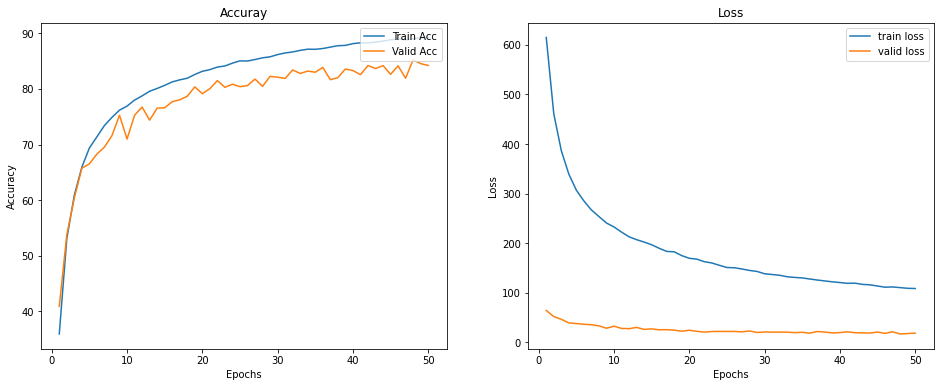

In [169]:


fig = plt.figure(figsize=(16,6))

plt.subplot(121)
plt.plot(np.arange(1,NUM_EPOCHS+1),train_acc_array)
plt.plot(np.arange(1,NUM_EPOCHS+1),val_acc_array)
plt.title("Accuray")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Acc","Valid Acc"],loc = "upper right")


plt.subplot(122)
plt.plot(np.arange(1,NUM_EPOCHS+1,dtype=int),train_loss_array)
plt.plot(np.arange(1,NUM_EPOCHS+1,dtype=int),val_loss_array)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'valid loss'], loc="upper right")

plt.show()

In [170]:
# can you create a subset of params exclusing pruned weights ?